# Calling genotypes, prevalences and filtering data
This program analyzes tables of counts. In the prior "variant calling" step of the program, mutation counts were generated for each sample by annotating the VCF file generated by freebayes, using SNPEff to assign amino acid names to mutations.

The count tables are intended to be as "raw" as possible. In this part of the analysis we will:
1. apply various filters to the count tables, considering a mutation 'sampled' for a sample if it passes the filters for that sample.
2. choose the level of detail of geographic locations we care about from a metadata file
3. summarize the number of filtered samples at each location that had the mutation and the total number of filtered samples at each location, where the 'prevalence' of a mutation at a location is the first number divided by the second number
4. graph the prevalences and filtered sample sizes on a map
5. (optional) - apply additional filtering for re-evaluation of prevalence data.

In [14]:
# Edit
output_folder = '2021_3_1_output'
mutation_count_file = "longitudinal_AA_tables/2021_AA_tables/alternate_AA_table.csv"
mutation_coverage_file = "longitudinal_AA_tables/2021_AA_tables/coverage_AA_table.csv"
metadata_table = "cleaned_metadata/2021_cleaned_kagera_metadata.csv"

# how many reads (or, more accurately, UMIs) do we need spanning the genomic coordinates of a mutation in order to
# consider the coordinates "sequenced" for a given sample? If UMI count is below min_coverage, the sample will be
# marked as "missing" for the mutation of interest.
min_coverage = 3

# If min_coverage is achieved in the sample, how many UMIs do we need that support the mutant (or alternate) allele
# in order to consider the alternate allele "present" in the sample? Otherwise if min_coverage is surpassed but
# min_count is not, the sample will be marked as matching the reference allele.
min_count = 1

# Is there a number that min_count/min_coverage needs to surpass before we consider an alternate allele "present" in a
# sample? Our usual answer is 'no' so we generally set this to '0' - but you may not want to count an alternate allele
# present if it's found in a very low fraction of the UMIs associated with a sample, even if the absolute number of UMIs
# associated with the alternate allele is above your threshold.
min_freq = 0

# Don't Edit below
import sys
sys.path.append("src")
import background as bg
all_columns, mutation_dict, filtered_mutations, mutation_counts, mutation_coverage = bg.get_mutation_counts(mutation_count_file, mutation_coverage_file)
print('observed missense mutations are:')
print(filtered_mutations)
print('')
metadata_columns = bg.get_metadata_columns(metadata_table, separator=',')
print('metadata columns are: ')
print(metadata_columns)

observed missense mutations are:
['crt-Asp17Glu', 'crt-Asp24Tyr', 'crt-Gly38Asp', 'crt-Phe48Leu', 'crt-Cys72Ser', 'crt-Met74Ile', 'crt-Asn75Glu', 'crt-Lys76Thr', 'crt-Thr93Ser', 'crt-His97Leu', 'crt-His97Tyr', 'crt-Cys101Phe', 'crt-Phe106Ser', 'crt-Arg122Gly', 'crt-Met135Leu', 'crt-Val141Leu', 'crt-Phe145Ile', 'crt-Leu215Phe', 'crt-Ile218Phe', 'crt-Ala220Ser', 'crt-Gln271Glu', 'crt-Asn326Ser', 'crt-Met343Leu', 'crt-Gly353Val', 'crt-Ala355Thr', 'crt-Ile356Thr', 'crt-Phe364Leu', 'crt-Arg371Ile', 'crt-Glu372Lys', 'crt-Met403Ile', 'crt-Glu409Asp', 'crt-Val418Ala', 'crt-Ile422Val', 'cytb-Phe3Tyr', 'cytb-Tyr4Asn', 'cytb-Val9Ala', 'cytb-Val9Ile', 'cytb-Ile14Leu', 'cytb-Ile41Leu', 'cytb-Asp53Glu', 'cytb-Val54Ile', 'cytb-Ser55Thr', 'cytb-Val85Ile', 'cytb-Leu97Val', 'cytb-Tyr99Phe', 'cytb-Met133Ile', 'cytb-Phe178Leu', 'cytb-Gly180Ala', 'cytb-Leu206Phe', 'cytb-Leu214Ile', 'cytb-Ile226Leu', 'cytb-Leu228Ile', 'cytb-Ile231Val', 'cytb-Leu234Phe', 'cytb-Pro243Thr', 'cytb-Asp244Asn', 'cytb-Ala246Thr', 

In [15]:
# Which mutations would you like to graph? A full list of sequenced plus key mutations from targets.tsv is created when
#you run the code in the cell above - this outputs the full list of available mutations to choose from.

#example if you want only "key mutations from the targets.tsv file found in the project_resources folder" plus k13 mutations
#mutation_column=open('/opt/project_resources/targets.tsv').readline().strip().split('\t').index('mutation_name')
#mutations_of_interest=[line.strip().split('\t')[mutation_column] for line in open('/opt/project_resources/targets.tsv')][1:]
#k13_muts=[mut for mut in filtered_mutations if 'k13' in mut]
#mutations_of_interest+=['dhps-Ala437Gly'] #targets.tsv file seems to be missing this key mutation
#mutations_of_interest+=k13_muts #add any additional found k13 mutations
#mutations_of_interest=list(set(mutations_of_interest)) #remove any duplicates

#example if you want only mutations from the AA tables from a specific gene
#mutations_of_interest=[mutation for mutation in filtered_mutations if 'k13' in mutation]

#example if you want to manually set the mutations to analyze
# mutations_of_interest=[
# 'dhfr-ts-Asn51Ile', 'dhfr-ts-Cys59Arg', 'dhfr-ts-Ser108Asn', 'dhfr-ts-Ile164Leu',
# 'mdr1-Asn652Asp', 'mdr1-Asn86Tyr', 'mdr1-Asp1246Tyr', 'mdr1-Asp650Asn',
# 'mdr1-Tyr184Phe', 'crt-Met74Ile', 'crt-Asn75Glu', 'crt-Lys76Thr',
# 'crt-Gln271Glu', 'crt-Arg371Ile', 'dhps-Ala437Gly', 'dhps-Lys540Glu',
# 'dhps-Ala581Gly', 'k13-Arg561His']

#In my case I'm interested in all of the mutations from the AA table
mutations_of_interest=filtered_mutations

# In the metadata sheet (reproduced in the table output from the cell above), which column contains sample names and
# which column contains the names of the locations you'd like to plot (or summarize by)?
sample_column='Sample_ID'
summary_column='District'

# don't edit
bg.create_prevalences_input_table(mutations_of_interest, mutation_dict, all_columns, mutation_counts, mutation_coverage, output_folder, min_count, min_coverage, min_freq)
prevalences = bg.calculate_prevalences(output_folder,metadata_table, sample_column, summary_column, mutations_of_interest, separator=',')
prevalences.head(10)

,Latitude,Longitude,crt-Asp17Glu,crt-Asp24Tyr,crt-Gly38Asp,crt-Phe48Leu,crt-Cys72Ser,crt-Met74Ile,crt-Asn75Glu,crt-Lys76Thr,...,mdr1-Asn1106Tyr,mdr1-Met1191Ile,mdr1-Phe1194Leu,mdr1-Tyr1197Asn,mdr1-Gln1198Lys,mdr1-Asn1199Ser,mdr1-Val1206Leu,mdr1-Gln1216His,mdr1-Asp1246Tyr,mdr1-Leu1250Ile
District,,,,,,,,,,,,,,,,,,,,,
Biharamulo,-2.810810,31.688700,0 (0/20),0.1 (2/20),0 (0/20),0 (0/20),0 (0/20),0.05 (1/20),0.05 (1/20),0.05 (1/20),...,0 (0/20),0 (0/20),0.05 (1/20),0 (0/20),0 (0/20),0 (0/20),0 (0/20),0 (0/20),0 (0/20),0 (0/20)
Bukoba DC,-1.425575,31.560196,0 (0/37),0.1351 (5/37),0 (0/37),0 (0/37),0 (0/38),0.0526 (2/38),0.0526 (2/38),0.0526 (2/38),...,0 (0/35),0 (0/35),0 (0/35),0.0286 (1/35),0.0857 (3/35),0 (0/35),0 (0/35),0 (0/35),0.0256 (1/39),0 (0/39)
Karagwe,-1.719199,31.024272,0 (0/118),0.1513 (18/119),0 (0/107),0 (0/107),0 (0/115),0.0087 (1/115),0.0087 (1/115),0.0087 (1/115),...,0 (0/94),0 (0/76),0 (0/76),0 (0/76),0.0132 (1/76),0 (0/76),0 (0/76),0 (0/76),0.0813 (10/123),0 (0/123)
Kyerwa,-1.369493,30.824481,0 (0/101),0.1584 (16/101),0 (0/100),0 (0/100),0 (0/110),0.0091 (1/110),0.0091 (1/110),0.0091 (1/110),...,0 (0/89),0 (0/84),0 (0/84),0 (0/84),0.0119 (1/84),0 (0/84),0 (0/84),0 (0/84),0.0185 (2/108),0 (0/108)
Misenyi,-1.254520,31.420400,0 (0/22),0.0909 (2/22),0 (0/25),0 (0/25),0 (0/25),0.04 (1/25),0.04 (1/25),0.04 (1/25),...,0 (0/21),0 (0/24),0 (0/24),0 (0/24),0 (0/24),0 (0/24),0 (0/24),0 (0/24),0.0741 (2/27),0 (0/27)
Muleba,-1.800184,31.541411,0 (0/143),0.1096 (16/146),0 (0/143),0 (0/143),0 (0/151),0.0132 (2/151),0.0132 (2/151),0.0132 (2/151),...,0 (0/131),0 (0/138),0 (0/138),0 (0/138),0 (0/138),0 (0/138),0 (0/138),0 (0/138),0.0062 (1/161),0 (0/161)
Ngara,-2.496598,30.616153,0 (0/131),0.2214 (29/131),0 (0/119),0 (0/119),0 (0/127),0.2441 (31/127),0.2441 (31/127),0.2441 (31/127),...,0.0101 (1/99),0 (0/102),0 (0/102),0 (0/102),0 (0/102),0 (0/102),0 (0/102),0 (0/102),0.0152 (2/132),0 (0/132)
overall,NaN,NaN,0 (0/572),0.1528 (88/576),0 (0/551),0 (0/551),0 (0/586),0.0666 (39/586),0.0666 (39/586),0.0666 (39/586),...,0.002 (1/489),0 (0/479),0.0021 (1/479),0.0021 (1/479),0.0104 (5/479),0 (0/479),0 (0/479),0 (0/479),0.0295 (18/610),0 (0/610)


# Plot Scatter map

In [16]:
#loads a dropdown menu so a user can choose one mutation of interest to graph
# RUN
import os
import ipywidgets as widgets
variants_of_interest=open(os.path.join(output_folder, "prevalence_summary.tsv")).readline().strip().split('\t')[3:]
variant = widgets.Dropdown(
    options=variants_of_interest,
    description='variant:',
    disabled=False,
)
# Don't edit
country, country_shortcuts = bg.generate_country_dropdown()
print("Country and Variant of Interest:\n")
display(country)
display(variant)

Country and Variant of Interest:



Dropdown(description='Country:', options=('DRC', 'Uganda', 'Tanzania'), value='DRC')

Dropdown(description='variant:', options=('crt-Asp17Glu', 'crt-Asp24Tyr', 'crt-Gly38Asp', 'crt-Phe48Leu', 'crt…

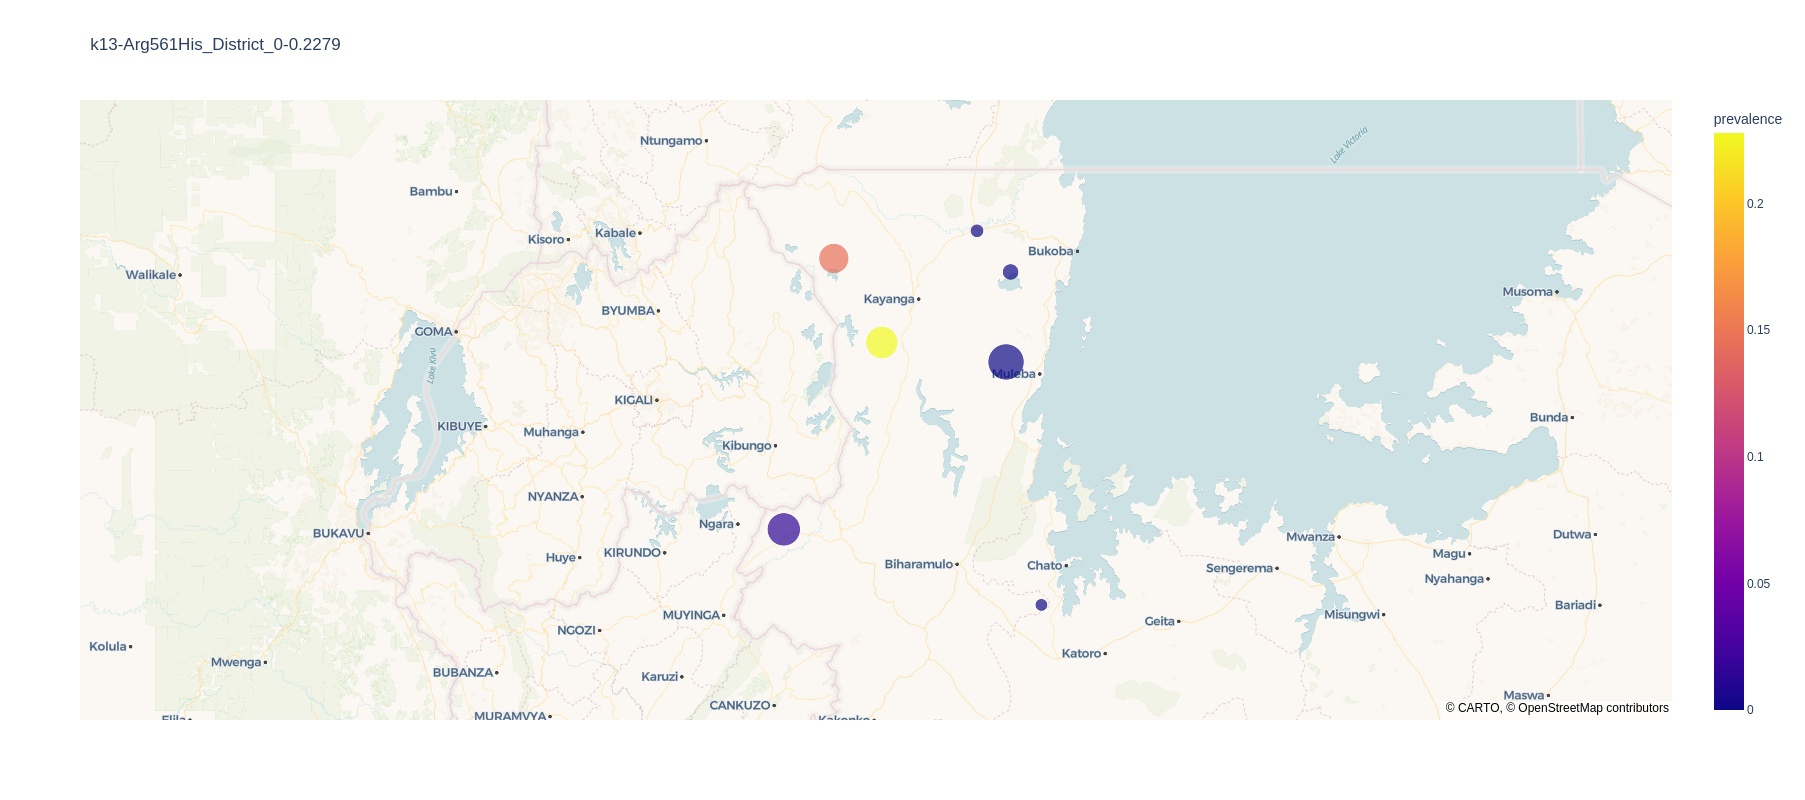

In [17]:
# Reads in a country using the dropdown menu (above) or the (currently commented out) manual values below
# RUN
chosen_country=country.value
chosen_variant=variant.value
zoom_level=country_shortcuts[chosen_country]['zoom']
latitude=country_shortcuts[chosen_country]['lat']
longitude=country_shortcuts[chosen_country]['lon']
# OPTIONAL USER INPUT:
# You can override the values above and set a custom zoom level and centering below by commenting these lines in
zoom_level=7.4
latitude=-2
longitude=31

# graphs the mutation of interest
fig = bg.make_detail_graph(chosen_variant, summary_column, output_folder, zoom_level, latitude, longitude)
fig.show()
title_string=f'{chosen_variant}_{summary_column}'
fig.write_image(os.path.join(output_folder, title_string+'.svg'))
fig.write_image(os.path.join(output_folder, title_string+'.png'))
fig.write_html(os.path.join(output_folder, title_string+'.html'))

## Static map of prevalences
Creates an SVG file of mapped mutations

In [ ]:
svg_country = bg.get_countries_from_geojson()
display(svg_country)

In [ ]:
# Edit

graph_states_provinces = True
latitude_range = [-12.6, 1.0]
longitude_range = [28, 42]
scale_factor=3

# additional labels to put on graph
labels = [
    ['Uganda', -0.24, 31],
    ['Rwanda', -1.84, 30],
    ['Burundi', -2.84, 30],
    ['Kenya', -0.2, 37.5],
    ['DRC', -7.0, 29],
    ['Zambia', -10.0, 31],
    ['Malawi', -12.0, 34],
    ['Mozambique', -12.2, 38]
]
annotation_font_size = 8

# title text
title_text = variant.value+' Prevalence'
title_size = 20

# Don't Edit
fig = bg.create_static_maps(
    variant.value,
    svg_country.value,
    graph_states_provinces,
    latitude_range,
    longitude_range,
    scale_factor,
    labels,
    annotation_font_size,
    title_text,
    title_size,
    output_folder,
    summary_column
)
fig.update_layout(width=1000, height=750)
fig.show()

## Bar Chart
Creates a Bar chart of mutation prevalences in the overall dataset

In [ ]:
# RUN
# This code generates a bar chart for your mutations of interest
def get_prevalences(prevalence_file, mutation_list):
	prevalence_dict={'mutations':[], 'prevalences':[], 'gene_name':[]}
	h_dict={}
	for line_number, line in enumerate(open(prevalence_file)):
		line=line.strip().split('\t')
		if line_number==0:
			for column_number, column in enumerate(line):
				h_dict[column]=column_number
		elif line[0]=='overall':
			for mutation in mutation_list:
				if mutation in h_dict:
					column=h_dict[mutation]
					prevalence=float(line[column].split(' ')[0])
					prevalence_dict['mutations'].append(mutation)
					prevalence_dict['prevalences'].append(prevalence)
					prevalence_dict['gene_name'].append(mutation.split('-')[0])
				else:
					print(mutation, f'is not found in {prevalence_file}!!')
	return prevalence_dict

def make_bar_chart(prevalence_dict, graph_type="bar chart of variants_of_interest", y_max=1.0):
	import pandas as pd
	import plotly.express as px
	df = pd.DataFrame(prevalence_dict)
	fig1=px.bar(df, x='mutations', y='prevalences', color='gene_name', text_auto=False)
	fig1['layout']['xaxis']['title']=graph_type
	fig1['layout']['yaxis']['title']='overall prevalence'
	fig1.update_layout(yaxis=dict(range=[0, y_max]))
	fig1.write_html(f'{graph_type}.html')
	fig1.write_image(f'{graph_type}.svg')
	fig1.write_image(f'{graph_type}.png')
	return fig1
chart_name='output/drug resistance mutations'
y_max=1.0

In [ ]:
# OPTIONAL USER INPUT
# User can optionally reset the variants_of_interest to graph, chart_name, and y_max values (e.g. by commenting in one
#of the blocks of lines below), otherwise the values will be pulled from the cells above

#variants_of_interest=['crt-Met74Ile', 'crt-Asn75Glu', 'crt-Lys76Thr','crt-Gln271Glu',
#'crt-Arg371Ile', 'dhfr-ts-Asn51Ile', 'dhfr-ts-Cys59Arg', 'dhfr-ts-Ser108Asn',
#'dhfr-ts-Ile164Leu', 'dhps-Ala437Gly', 'dhps-Lys540Glu', 'dhps-Ala581Gly',
#'mdr1-Asn86Tyr', 'mdr1-Tyr184Phe', 'mdr1-Asp650Asn', 'mdr1-Asn652Asp',
#'mdr1-Asp1246Tyr']
#chart_name='non-k13 mutations'
#y_max=1.0

#variants_of_interest=['k13-Lys108Glu', 'k13-His136Asn', 'k13-Lys189Asn', 'k13-Lys189Thr',
#'k13-Arg255Lys', 'k13-Leu258Met', 'k13-Gln271His', 'k13-Cys469Phe',
#'k13-Cys469Tyr', 'k13-Asn490Thr', 'k13-Arg561His', 'k13-Ala578Ser',
#'k13-Ala675Val']
#chart_name='k13 mutations'
#y_max=0.5


# NO USER INPUT BELOW
prevalence_dict=get_prevalences('output/prevalence_summary.tsv', variants_of_interest)
fig1=make_bar_chart(prevalence_dict, chart_name, y_max)
fig1.show()